In [81]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
from scipy.ndimage import convolve, generate_binary_structure

In [82]:
# Definimos la Longitud de la red:
N = 1000

# Generamos el estado inicial de la red:
init_random = np.random.random(N)
lattice_n = np.zeros(N)
lattice_n[init_random < 0.75] = 1
lattice_n[init_random >= 0.75] = -1
lattice_p = np.zeros(N)
lattice_p[init_random > 0.75] = 1
lattice_p[init_random <= 0.75] = -1

In [83]:
# Definimos la energía de la red:
def get_energy(lattice, h=0.0):
    # Hace simulación de vecino más cercano
    kern = [True, False, True]

    arr = -lattice * convolve(lattice, kern, mode='wrap')
    arr -= h * lattice
    return np.sum(arr)

In [84]:
@numba.jit(nopython=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0, times-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0, N)
        spin_i = spin_arr[x]  # initial spin
        spin_f = spin_i*-1  # proposed spin flip

        # compute change in energy
        E_i = 0
        E_f = 0
        if x > 0:
            E_i += -spin_i*spin_arr[x-1]
            E_f += -spin_f*spin_arr[x-1]
        if x < N-1:
            E_i += -spin_i*spin_arr[x+1]
            E_f += -spin_f*spin_arr[x+1]

        # 3 / 4. change state with designated probabilities
        dE = E_f-E_i
        if (dE > 0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x] = spin_f
            energy += dE
        elif dE <= 0:
            spin_arr[x] = spin_f
            energy += dE

        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy

    return net_spins, net_energy

In [85]:
spins, energies = metropolis(lattice_n, 1000, 0.2, get_energy(lattice_n))

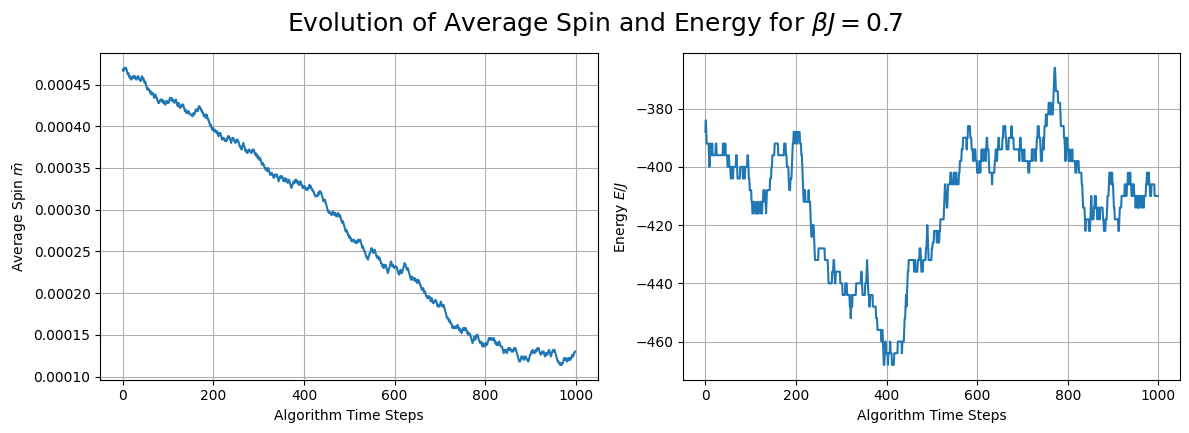

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(
    r'Evolution of Average Spin and Energy for $\beta J=$0.7', y=1.07, size=18)
plt.show()

In [87]:
# Ahora calculamos la magnetización y la energía para distintos valores de beta J:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 1000, bj, get_energy(lattice))
        ms[i] = spins[-800:].mean()/N**2
        E_means[i] = energies[-800:].mean()
        E_stds[i] = energies[-800:].std()
    return ms, E_means, E_stds


BJs = np.arange(1, 3, 0.05)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

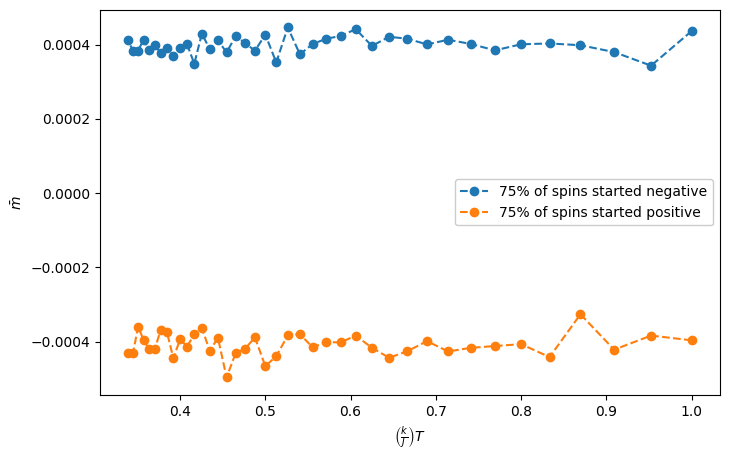

In [88]:
plt.figure(figsize=(8, 5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

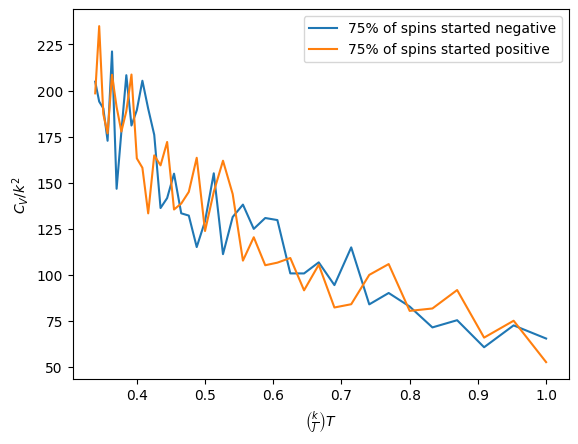

In [89]:
plt.plot(1/BJs, E_stds_n*BJs, label='75% of spins started negative')
plt.plot(1/BJs, E_stds_p*BJs, label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()

# Con torch


In [90]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import conv2d, conv3d
from scipy.ndimage import convolve, generate_binary_structure
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Device: ', device)

Device:  cpu


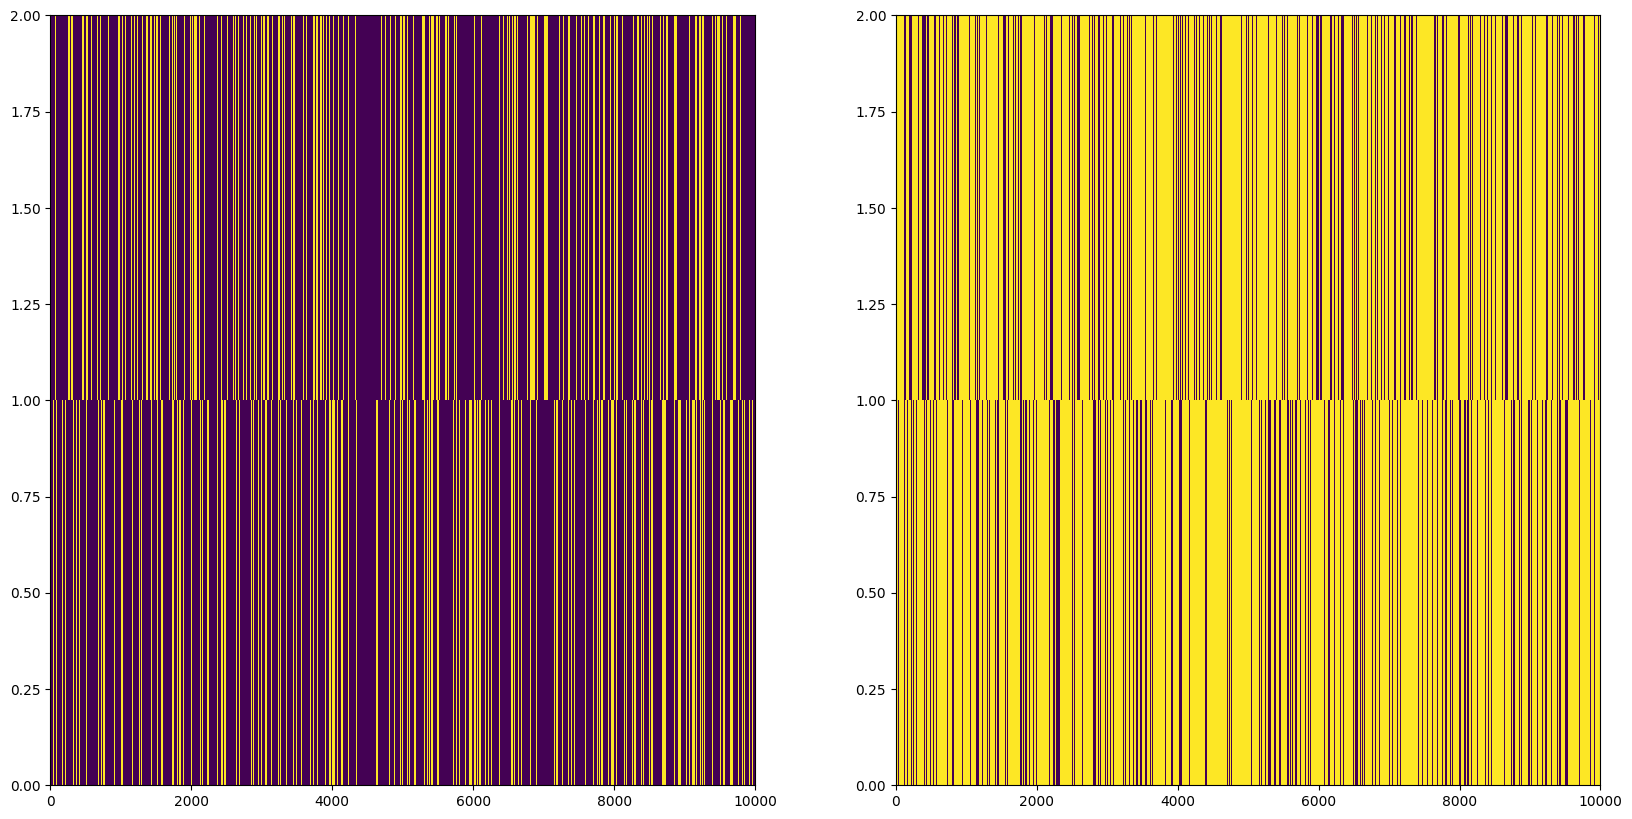

In [91]:
# Generamos el estado inicial de forma aleatoria
N = 10000
n2 = 2
# Creamos una matriz con números aleatorios
init_random = torch.rand((n2, N)).to(device)
lattice_n = torch.zeros((n2, N)).to(device)

# Para después crear una red con mayoría de spines positivos
lattice_n[init_random >= 0.75] = 1
lattice_n[init_random < 0.75] = -1

# Y repetimos para otra con la mayoría de espines negativos
init_random = torch.rand((n2, N)).to(device)
lattice_p = torch.zeros((n2, N)).to(device)
lattice_p[init_random >= 0.25] = 1
lattice_p[init_random < 0.25] = -1

# Unimos las dos redes para simular las dos a la vez
lattices = torch.stack([lattice_n, lattice_p]).unsqueeze(dim=1)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.pcolormesh(lattice_n.cpu())
plt.subplot(1, 2, 2)
plt.pcolormesh(lattice_p.cpu())
plt.show()

In [92]:
kern = generate_binary_structure(2, 1)
kern[1, 1] = False
kern[0, 1] = False
kern[2, 1] = False
print(kern)

[[False False False]
 [ True False  True]
 [False False False]]


In [93]:
# Definimos la energía del sistema
def get_energy_arr(lattices, h=0.0):
    # Usamos un kernel para aplicar la interacción con los vecinos más cercanos
    kern = generate_binary_structure(2, 1)
    kern[1, 1] = False
    kern[0, 1] = False
    kern[2, 1] = False
    kern = torch.tensor(kern.astype(np.float32)).unsqueeze(
        dim=0).unsqueeze(dim=0).to(device)
    arr = -lattices * conv2d(lattices, kern, padding='same')
    arr -= lattices * h
    return arr


def get_energy(lattices):
    # Sumamos las energías para obtener la energía de la red
    return get_energy_arr(lattices).sum(axis=(1, 2, 3))


def get_dE_arr(lattices):
    return -2*get_energy_arr(lattices)

In [94]:
# Definimos el algoritmo de metrópolis
def metropolis(spin_tensor_batch, times, BJs):
    energies = []
    avg_spins = []
    spin_tensor_batch = torch.clone(spin_tensor_batch)
    BJs = BJs.reshape([-1, 1, 1, 1])
    for t in range(times):
        i = np.random.randint(0, 2)
        j = np.random.randint(0, 2)
        dE = get_dE_arr(spin_tensor_batch)[:, :, i::2, j::2]
        change = (dE >= 0)*(torch.rand(dE.shape).to(device)
                            < torch.exp(-BJs*dE)) + (dE < 0)
        spin_tensor_batch[:, :, i::2, j::2][change] *= -1
        energies.append(get_energy(spin_tensor_batch))
        avg_spins.append(spin_tensor_batch.sum(axis=(1, 2, 3))/N**2)
    return torch.vstack(avg_spins), torch.vstack(energies)

In [95]:
# Resolvemos para obtener los spines y la energía.
BJs = 0.5*torch.ones(lattices.shape[0]).to(device)
spins, energies = metropolis(lattices, 1000, BJs)

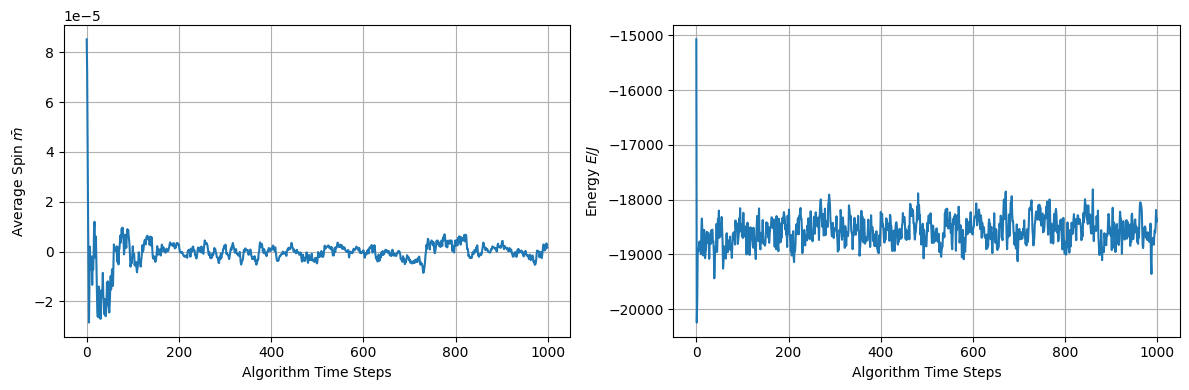

In [96]:
# Representamos La media del spin en cada iteración
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.plot(spins[:, 1].cpu())
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies[:, 1].cpu())
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
plt.show()

In [97]:
# Ahora vamos a obtener la magnetización y la energía en función de la temperatura
# Tomando m como función de la temperatura T = 1/kB = J/(BJ)k

def get_spin_energy(lattice, BJs):
    lattices = lattice.unsqueeze(dim=0).repeat(len(BJs), 1, 1, 1)
    spins, energies = metropolis(lattices, 1000, BJs)
    spins_avg = torch.mean(spins[-400:], axis=0)
    spins_std = torch.std(spins[-400:], axis=0)
    energies_avg = torch.mean(energies[-400:], axis=0)
    energies_std = torch.std(energies[-400:], axis=0)
    return spins_avg, spins_std, energies_avg, energies_std


BJs2 = 1/torch.linspace(0.1, 3, 20).to(device)
spins_avg_n2, spins_std, E_means_n2, E_stds_n2 = get_spin_energy(
    lattice_n, BJs2)
spins_avg_p2, spins_std, E_means_p2, E_stds_p2 = get_spin_energy(
    lattice_p, BJs2)

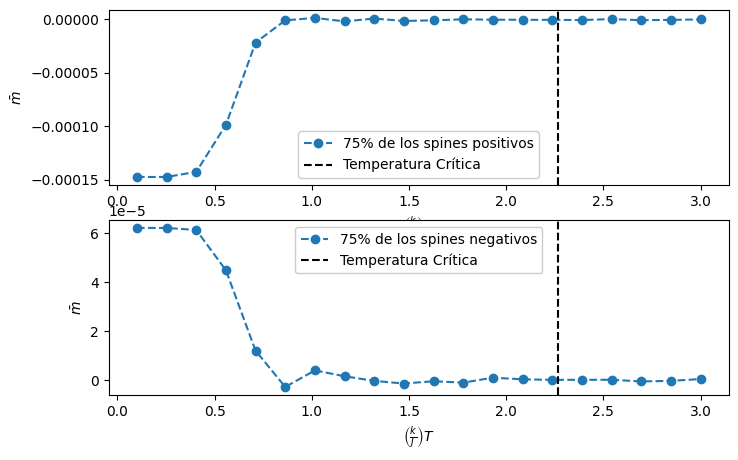

In [98]:
# Representamos los resultados
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
plt.plot(1/BJs2.cpu(), spins_avg_n2.cpu(), 'o--',
         label='75% de los spines positivos')
plt.axvline(2.269, color='k', linestyle='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.subplot(2, 1, 2)
plt.plot(1/BJs2.cpu(), spins_avg_p2.cpu(), 'o--',
         label='75% de los spines negativos')
plt.axvline(2.269, color='k', linestyle='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

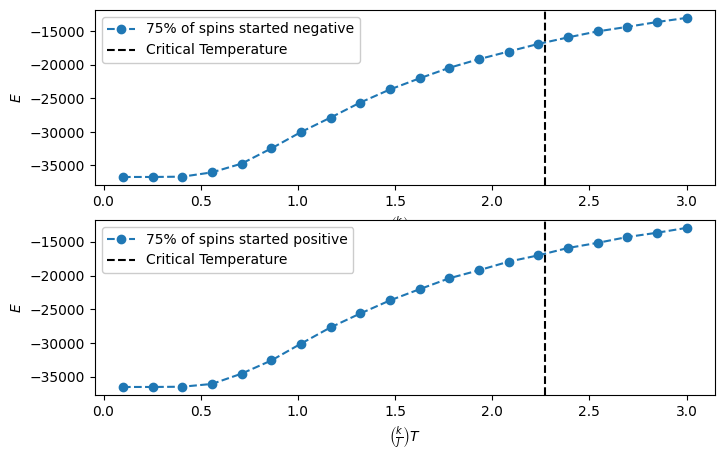

In [99]:
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
plt.plot(1/BJs2.cpu(), E_means_n2.cpu(), 'o--',
         label='75% of spins started negative')
plt.axvline(2.269, color='k', linestyle='--', label='Critical Temperature')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$E$')
plt.legend(facecolor='white', framealpha=1)
plt.subplot(2, 1, 2)
plt.plot(1/BJs2.cpu(), E_means_p2.cpu(), 'o--',
         label='75% of spins started positive')
plt.axvline(2.269, color='k', linestyle='--', label='Critical Temperature')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$E$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

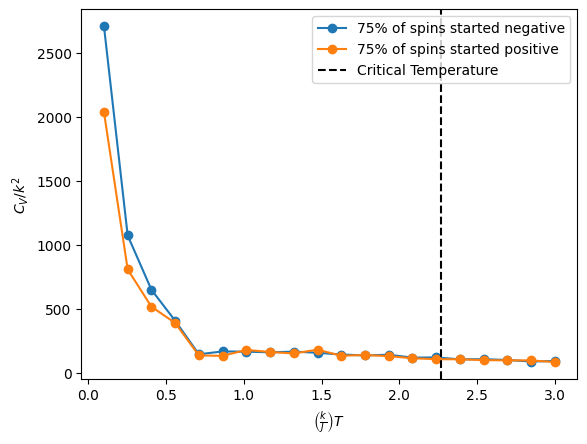

In [100]:
plt.plot(1/BJs2.cpu(), E_stds_n2.cpu()*BJs2.cpu(),
         '-o', label='75% of spins started negative')
plt.plot(1/BJs2.cpu(), E_stds_p2.cpu()*BJs2.cpu(),
         '-o', label='75% of spins started positive')
plt.axvline(2.27, color='k', linestyle='--', label='Critical Temperature')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()

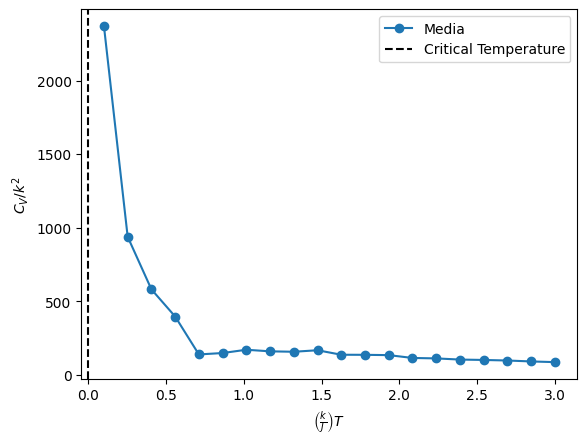

In [101]:

plt.plot(1/BJs2.cpu(), (E_stds_n2.cpu()*BJs2.cpu() +
         E_stds_p2.cpu()*BJs2.cpu())/2, '-o', label='Media')
plt.axvline(0, color='k', linestyle='--', label='Critical Temperature')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()

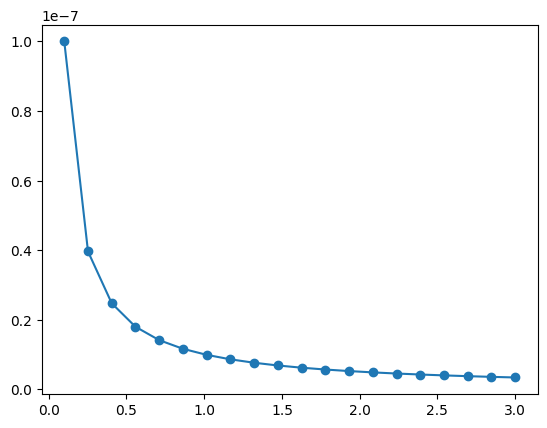

In [102]:
#plt.plot(1/BJs2.cpu(), E_stds_n_p2.cpu(), '-o', label='Media')
plt.plot(1/BJs2.cpu(), (1/BJs2.cpu())**-1/N**2, '-o', label='Media')

# Modelo de campo medio


In [103]:
# Definimos la energía del sistema
def get_energy_arr(lattices, h=0.0):
    # Usamos un kernel para aplicar la interacción todos con todos

    arr = -lattices * lattices 
    arr -= lattices * h
    return arr


def get_energy(lattices):
    # Sumamos las energías para obtener la energía de la red
    return get_energy_arr(lattices).sum(axis=(1, 2, 3))


def get_dE_arr(lattices):
    return -2*get_energy_arr(lattices)

In [104]:
# Resolvemos para obtener los spines y la energía.
BJs = 0.5*torch.ones(lattices.shape[0]).to(device)
spins, energies = metropolis(lattices, 1000, BJs)

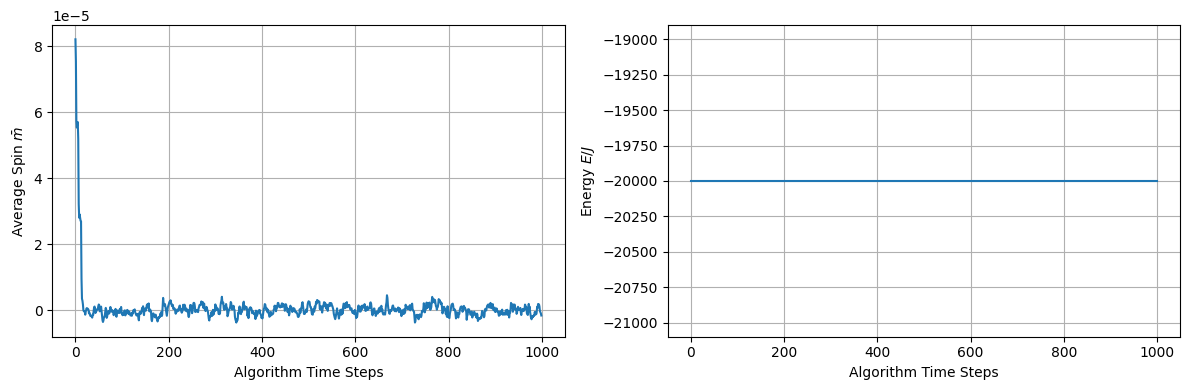

In [105]:
# representamos La media del spin en cada iteración
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.plot(spins[:, 1].cpu())
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies[:, 1].cpu())
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
plt.show()


In [106]:
# Ahora vamos a obtener la magnetización y la energía en función de la temperatura
# Tomando m como función de la temperatura T = 1/kB = J/(BJ)k

def get_spin_energy(lattice, BJs):
    lattices = lattice.unsqueeze(dim=0).repeat(len(BJs), 1, 1, 1)
    spins, energies = metropolis(lattices, 1000, BJs)
    spins_avg = torch.mean(spins[-400:], axis=0)
    spins_std = torch.std(spins[-400:], axis=0)
    energies_avg = torch.mean(energies[-400:], axis=0)
    energies_std = torch.std(energies[-400:], axis=0)
    return spins_avg, spins_std, energies_avg, energies_std



In [107]:
spins_avg_n2, spins_std, E_means_n2, E_stds_n2 = get_spin_energy(lattice_n, BJs2)

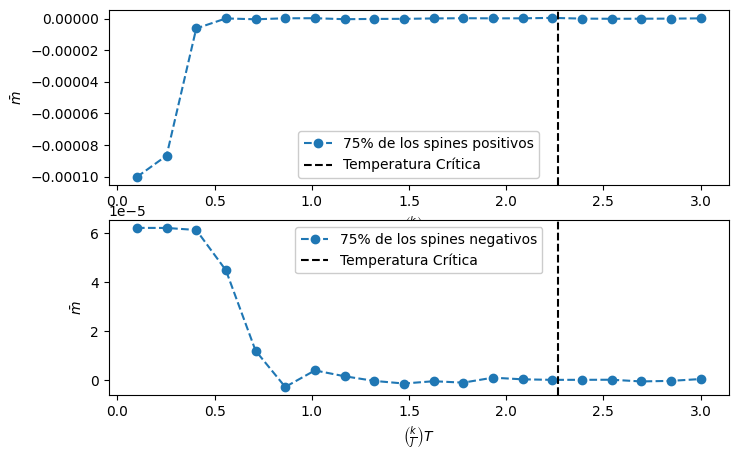

In [108]:
# representa los resultados
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
plt.plot(1/BJs2.cpu(), spins_avg_n2.cpu(), 'o--', label='75% de los spines positivos')
plt.axvline(2.269, color='k', linestyle='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.subplot(2, 1, 2)
plt.plot(1/BJs2.cpu(), spins_avg_p2.cpu(), 'o--', label='75% de los spines negativos')
plt.axvline(2.269, color='k', linestyle='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()


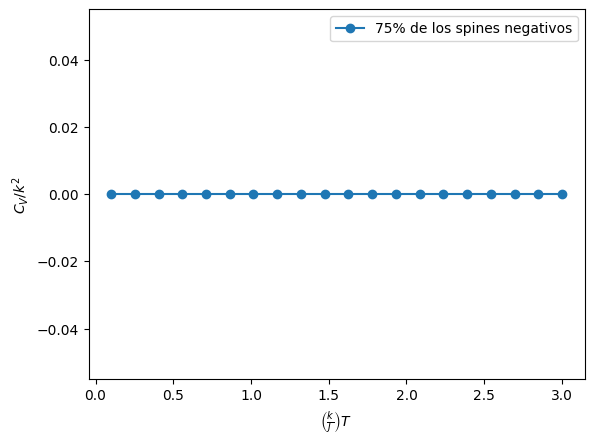

In [109]:
# representamos c_v

plt.plot(1/BJs2.cpu(), E_stds_n2.cpu()*BJs2.cpu(), '-o', label='75% de los spines negativos')

plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()
